# Quantum Phase Estimation of Random Hermitian Matrix

Authors: Takumi Kato (Blueqat inc.), Maho Nakata (Riken), Shinya Morino, Seiya Sugo (Quemix inc.), Yuichiro Minato (Blueqat inc.)

[Last time](113_pea_en.ipynb), we calculated the eigenvalues of matrices of the Z-Gate and the X-Gate. This time, we perform the quantum phase estimation of a random generated 2x2 Hermitian matrix.

Calculating eigenvalues of Hermitian matrices is useful for finding physical quantities in quantum mechanics. It has wide range of applications in fields such as quantum chemistry and quantum simulation.

## Quantum Phase Estimation of Hermitian Matrix with Eigenvalues Summing up to Zero

The general idea of quantum phase estimation for Hermitian matrices is the same as previous one. In the previous case, we prepared Controlled-Z gate and Controlled-X gate for estimating Z-Gate and X-Gate as Controlled-U gate. However, generally, a Hermitian matrix is not a unitary matrix. Therefore, we cannot prepare Controlled-U gate directly.

Just to conclude, we need to prepare Controlled-$e^{2\pi i\hat H}$ gate as Controlled-U gate for the Hermitian matrix$\hat H$ and the quantum circuit which gives an eigenvector of $\hat H$. By using these circuit and gate, we can perform quantum phase estimation and obtain the eigenvalue.

The following instructions are little bit difficult. So you can skip ahead and read the code. To understanding this, you need to know [matrix exponential](https://en.wikipedia.org/wiki/Matrix_exponential).

Let $\hat H$ be a Hermitian matrix with eigenvalues summing up to 0.

When $\hat H$ has pairs of eigenvalue and eigenvector$\{(\lambda_j, \left|\psi_j\right\rangle)\}$, $$\hat H\left|\psi_j\right\rangle = \lambda_j \left|\psi_j\right\rangle$$ is satisfied for all $j$.
$\{\lambda_j\}$ are real number because $\hat H$ is Hermitian.

In the previous case, $\hat H$ was $\hat H = Z$ or $\hat H = X$ and we used Controlled-Z or Controlled-X gate for phase kickback. However, generally, we cannot make Controlled-$\hat H$ gate because $\hat H$ is not a unitary matrix, so we have to find another way.

Here, we consider the quantum phase estimation of a unitary matrix $U = e^{2\pi i\hat H}$.

### Is $U = e^{2\pi i\hat H}$ a unitary matrix?

To proof $U U^\dagger = I$, we consider $U^\dagger$.
$$\begin{eqnarray}
U^\dagger &=& (e^{2\pi i\hat H})^\dagger\nonumber\\
&=& (\sum_n^\infty \frac{(2\pi i\hat H)^n}{n!})^\dagger\nonumber\\
&=& \sum_n^\infty \frac{((2\pi i\hat H)^n)^\dagger}{n!}\nonumber\\
&=& \sum_n^\infty \frac{(-2\pi i\hat H^\dagger)^n)}{n!}\nonumber\\
&=& \sum_n^\infty \frac{(-2\pi i\hat H)^n)}{n!}\nonumber\\
&=& e^{-2\pi i\hat H}.\nonumber
\end{eqnarray}$$
Therefore, $U U^\dagger = e^{2\pi i\hat H} e^{-2\pi i\hat H}$. Because $[2\pi i\hat H, -2\pi i\hat H] = 0$, $e^{2\pi i\hat H} e^{-2\pi i\hat H} = e^{2\pi i\hat H -2\pi i\hat H} = e^{0\hat H} = I$. So, $U U^\dagger = I$ i.e. $U$ is a unitary matrix.

### What is the eigenvalues and eigenvectors of $U$? Is it related with them of $\hat H$?

We proof that the eigenvector of $U$ is as same as the eigenvector of $\hat H$, and find its corresponding eigenvalue.

Let $\lambda_j, \left|\psi_j\right\rangle$ be a pair of an eigenvalue and an eigenvector of $\hat H$. Then,
$$\begin{eqnarray}
U \left|\psi_j\right\rangle &=& (\sum_n^\infty \frac{(2\pi i\hat H)^n}{n!})\left|\psi_j\right\rangle\nonumber\\
&=& \sum_n^\infty \frac{(2\pi i)^n \hat H^n \left|\psi_j\right\rangle}{n!}\nonumber\\
&=& \sum_n^\infty \frac{(2\pi i)^n \lambda_j^n \left|\psi_j\right\rangle}{n!}\nonumber\\
&=& \sum_n^\infty \frac{(2\pi i)^n \lambda_j^n}{n!}\left|\psi_j\right\rangle\nonumber\\
&=& \sum_n^\infty \frac{(2\pi i \lambda_j)^n}{n!}\left|\psi_j\right\rangle\nonumber\\
&=& e^{2\pi i \lambda_j}\left|\psi_j\right\rangle.\nonumber
\end{eqnarray}$$
Therefore, $\left|\psi_j\right\rangle$ is an eigenvector of $U$ and its corresponding eigenvalue is $e^{2\pi i \lambda_j}$.

So, we can obtain the eivenvalue $\lambda_j$ of $\hat H$ by the quantum phase estimation of
$$U\left|\psi_j\right\rangle = e^{2\pi i\lambda_j} \left|\psi_j\right\rangle.$$

## Implementation
First, we import required libraries. In this time, we use numba backend.

In [1]:
import math
import cmath
import random
import numpy as np

from blueqat import *
from blueqat.pauli import X, Y, Z, I

BlueqatGlobalSetting.set_default_backend('numba')
pi = math.pi

# Version check for Blueqat
try:
    Circuit().r(0.1)[0].run()
except AttributeError:
    raise ImportError('Blueqat version is old.')

Next, we make a random Hermitian matrix $\hat H$.

To obtain the eigenvalue by quantum phase estimation, we also need
- A quantum circuit which gives the eigenvector of $\hat H$ corresponding with desired eigenvalue
- A quantum circuit which gives Controlled-$e^{i2\pi \hat H 2^n}$.

We will create them.

A Hermitian matrix can be decomposed into $\hat H = P D P^\dagger$
where $P$ is a unitary matrix, $D$ is a real diagonal matrix.

In this case, diagonal elements of $D$ are eigenvalues of $\hat H$ and each column of $P$ are eigenvalues of $\hat H$. Now, we're considering a 2x2 Hermitian with eigenvalues summing up to zero, so, elements of $D$ are $\pm E$ when $\hat H$ has an eigenvalue $E$.

Thus, we generate random real number $E$ and make $D$, then, generate random three real numbers $\theta, \phi, \lambda$ and make $P$ using U gate, i.e. $P = \mathrm{U}(\theta, \phi, \lambda)$. Here, we ignore the parameter $\gamma$ of U gate because it is irrelevant to eigenvalues.

Now, we can define the function which returns

- A Hermitian matrix $\hat H$
- An eigenvalue $E$, which we desired to calculate
- Parameters of U gate $\theta, \phi, \lambda$ which gives the eigenvector.

In [1]:
def is_hermitian(mat):
    """Check whether mat is Hermitian"""
    return np.allclose(mat, mat.T.conjugate())

def get_u_matrix(theta, phi, lam):
    """Get a unitary matrix U(theta, phi, lam)"""
    # Get sympy matrix via Circuit.to_unitary() and convert to numpy matrix
    u = Circuit().u(theta, phi, lam)[0].to_unitary()
    return np.array(u.tolist()).astype(np.complex64)

def random_hermitian():
    """Make random Hermitian and returns triplet
    (Hermitian, eigenvalue, parameters for U).
    """
    # Generate random eigenvalue
    eigval = random.random()
    # Generate random parameters for U
    theta = random.random()
    phi = random.random()
    lam = random.random()
    # Make Hermitian from them
    u = get_u_matrix(theta, phi, lam)
    hermitian = u @ np.diag([eigval, -eigval]) @ u.T.conjugate()
    # Check it is Hermitian
    assert is_hermitian(hermitian)
    # returns Hermitian, eigenvalue, parameters for U
    return hermitian, eigval, (theta, phi, lam)

OK. We will make a Hermitian.

In [3]:
H, E, (theta, phi, lam) = random_hermitian()
print(H)

[[ 0.90694015+0.j          0.13469137-0.03652766j]
 [ 0.13469137+0.03652766j -0.90694024+0.j        ]]


We can make an eigenvector using `theta, phi, lam` and U gate.

In [4]:
vec = Circuit().u(theta, phi, lam)[0].run()
print(vec)

[0.99708757+0.j         0.0736065 +0.01996173j]


Check `H vec = E vec`, it means, `E, vec` is a pair of eigenvalue and eigenvector of H.

In [5]:
np.allclose(np.dot(H, vec), E * vec)

True

Preparation is done. We will implement quantum phase estimation. We make the quantum circuit and calculate `E` by quantum phase estimation.

In [6]:
def iqft(c, q0, n_qubits):
    """Add inversed quantum Fourier transform operations to q0-th - (q0 + n_qubits)-th qubits of the circuit `c`"""
    for i in reversed(range(n_qubits)):
        angle = -0.5
        for j in range(i + 1, n_qubits):
            c.cr(angle * pi)[q0 + j, q0 + i]
            angle *= 0.5
        c.h[q0 + i]
    return c


def initial_circuit(theta, phi, lam):
    """Prepare a initial circuit which gives eigenvector."""
    return Circuit().u(theta, phi, lam)[0]


def apply_cu(c, ctrl, theta, phi, lam, eigval, n):
    """Append Controlled-U^(2^n) to the circuit `c`.
    Controll qubit is `ctrl`, target qubit is 0.
    
    This function requires eigenvalue `eigval` as an argument.
    We make Controlled-U^(2^n) by using eigenvalue. You may feel we're cheating.
    You can make approximate Controlled-U^(2^n) circuit without eigenvalue,
    for example by using Suzuki-Trotter decomposition. In this case, you have to consider about precision.
    Generally, making efficient and high-precision Controlled-U^(2^n) circuit without cheating is difficult.
    """
    return c.u(-theta, -lam, -phi)[0].crz(-2 * pi * eigval * (2**n))[ctrl, 0].u(theta, phi, lam)[0]

def qpe_circuit(eigval, theta, phi, lam, precision):
    """Returns quantum phase estimation circuit from eigenvalue, parameters of U gate and
    precision (a number of binary digits) of phase estimation"""
    c = initial_circuit(theta, phi, lam)
    c.h[1:1 + precision]
    for i in range(precision):
        apply_cu(c, i + 1, theta, phi, lam, eigval, i)
    iqft(c, 1, precision)
    return c

Let's see the quantum circuit of quantum phase estimation.

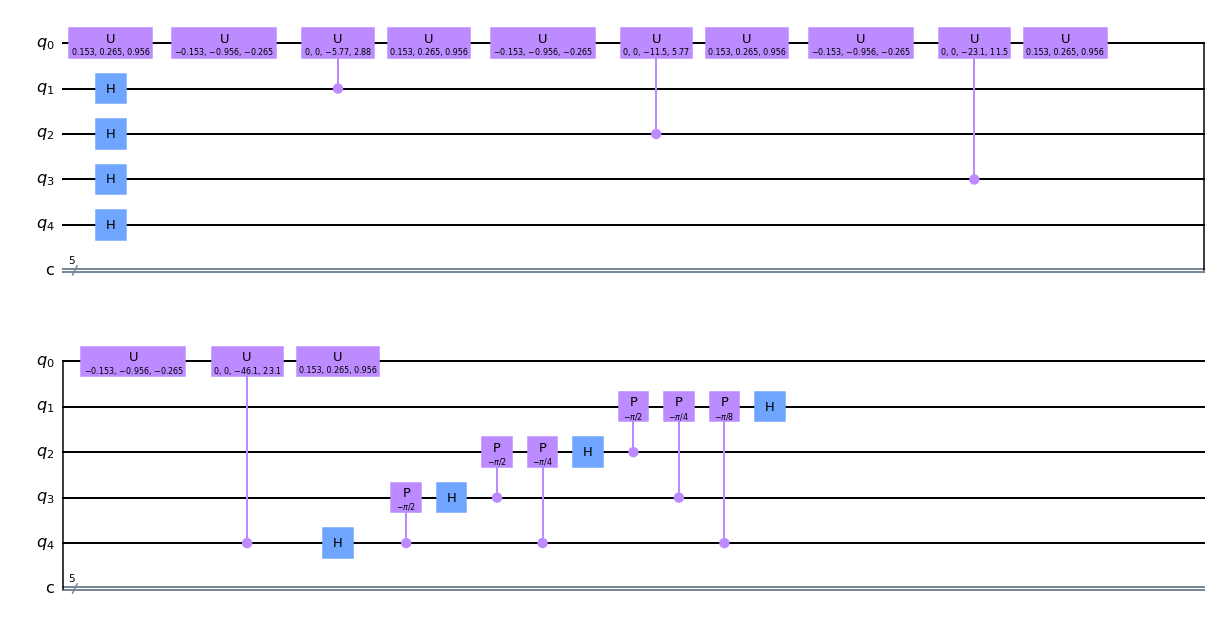

In [7]:
qpe_circuit(E, theta, phi, lam, 4).run_with_ibmq(returns='draw', output='mpl')

Then, we make a function for calculating the eigenvalue from observed result.

In [2]:
def run_qpe(c, shots=1000, max_candidates=5):
    """Run the circuit for quantum phase estimation and returns candidates of eigenvalue.
    shots: The number of running quantum circuit, max_candidates: Maximum number of candidates
    """
    cnt = c.m[1:].run(shots=shots)

    # Convert measured result to floating point value
    def to_value(k):
        k = k[1:] # Drop first element
        val = 0 # Value
        a = 1.0 
        for ch in k:
            if ch == '1':
                val += a
            a *= 0.5
        if val > 1:
            # When the phase > π, subtract 2π (phase is negative).
            val = val - 2
        return val

    return [(to_value(k), v) for k, v in cnt.most_common(max_candidates)]

Now, we can perform the quantum phase estimation. Let's see the result.

In [9]:
print('Eigenvalue (expected):', E) # It's expected value. We desire a value closed to it.
# We'll run small to high precision for comparison.
for precision in range(3, 16):
    print(precision, 'bit precision:')
    c = qpe_circuit(E, theta, phi, lam, precision)
    result = run_qpe(c, 1000, 3)
    for value, count in result:
        # Display a number of observation, obtained eigenvalue and a deviation from true eigenvalue.
        print(f'{count:<5}{value:<18}(deviation: {value - E: .3e})')
    print('')

Eigenvalue (expected): 0.9176146025886731
3 bit precision:
695  1.0               (deviation:  8.239e-02)
144  0.75              (deviation: -1.676e-01)
58   -0.75             (deviation: -1.668e+00)

4 bit precision:
695  0.875             (deviation: -4.261e-02)
175  1.0               (deviation:  8.239e-02)
38   0.75              (deviation: -1.676e-01)

5 bit precision:
710  0.9375            (deviation:  1.989e-02)
145  0.875             (deviation: -4.261e-02)
49   1.0               (deviation:  8.239e-02)

6 bit precision:
615  0.90625           (deviation: -1.136e-02)
232  0.9375            (deviation:  1.989e-02)
41   0.96875           (deviation:  5.114e-02)

7 bit precision:
773  0.921875          (deviation:  4.260e-03)
104  0.90625           (deviation: -1.136e-02)
40   0.9375            (deviation:  1.989e-02)

8 bit precision:
490  0.9140625         (deviation: -3.552e-03)
326  0.921875          (deviation:  4.260e-03)
60   0.90625           (deviation: -1.136e-02)

9 bi

Obtained value are near by true eigenvalue.

## Quantum Phase Estimation of Hermitian Matrix (without Eigenvalues Summing up to Zero)
Generally, the sum of eigenvalues of Hermitian matrix is not zero. In this case, we also can calculate the eigenvalue by quantum phase estimation, but we need to modify the circuit for Controlled-U gate.

Let $U$ be $e^{2\pi i\hat H}$. The sum of eigenvalues of $U$ is equivalent with a trace of $U$. So, we consider $\mathrm{tr}(U)$.
$$\begin{eqnarray}
\mathrm{tr}(U) &=& \mathrm{tr}\left(\sum_{n=0}^{\infty}\frac{(2\pi i \hat H)^n}{n!}\right)\nonumber\\
&=&\sum_{n=0}^{\infty}\mathrm{tr}\left(\frac{(2\pi i \hat H)^n}{n!}\right)\nonumber\\
&=&\sum_{n=0}^{\infty}\frac{(2\pi i \mathrm{tr}(\hat H))^n}{n!}\nonumber\\
&=&e^{2\pi i \mathrm{tr}(\hat H)}\nonumber.\\
\end{eqnarray}$$
Therefore, $\mathrm{tr}(U)$ is appeared with a global phase of $U$. We make Controlled-U gate with considering the global phase. i.e. We add a RZ gate into controll qubit.

In [10]:
def random_hermitian2():
    """Make random Hermitian matrix and returns
    Hermitian matrix, a pair of eigenvalues, parameters for U gate.
    """
    # Get random eigenvalues. The range of eigenvalues is -1 to 1.
    eigvals = [random.random() * 2 - 1, random.random() * 2 - 1]
    # Sorting eigenvalues. (You may comment out this line if you don't desire.)
    eigvals.sort()
    # Get random parameters for U gate.
    theta = random.random()
    phi = random.random()
    lam = random.random()
    # Make a Hermitian matrix from them.
    u = get_u_matrix(theta, phi, lam)
    hermitian = u @ np.diag(eigvals) @ u.T.conjugate()
    # Check if it is Hermitian.
    assert is_hermitian(hermitian)
    # Returns Hermitian, eigenvalues, parameters.
    return hermitian, eigvals, (theta, phi, lam)

In [11]:
H, eigvals, (theta, phi, lam) = random_hermitian2()
print(H)

[[-0.89623604-1.69406589e-21j -0.0328706 +1.96551910e-02j]
 [-0.0328706 -1.96551910e-02j -0.0411255 +0.00000000e+00j]]


In [12]:
def apply_cu2(c, ctrl, theta, phi, lam, eigvals, n):
    """Modify apply_cu and consider global phase also.
    argument `eigvals` is a pair of eigenvalues.
    """
    bias = sum(eigvals) / 2
    angle = (eigvals[0] - eigvals[1]) / 2
    return c.u(-theta, -lam, -phi)[0].crz(-2 * pi * angle * (2**n))[ctrl, 0].u(theta, phi, lam)[0].rz(pi * bias * (2**n))[ctrl]

def qpe_circuit2(eigvals, theta, phi, lam, precision):
    """Modify qpe_circuit2 for using apply_cu2."""
    c = initial_circuit(theta, phi, lam)
    c.h[1:1 + precision]
    for i in range(precision):
        apply_cu2(c, i + 1, theta, phi, lam, eigvals, i)
    iqft(c, 1, precision)
    return c

Then, we calculate first eigenvalue.

In [13]:
print('Eigenvalue (expected):', eigvals[0]) # It's expected value. We desire a value closed to it.
# We'll run small to high precision for comparison.
for precision in range(3, 16):
    print(precision, 'bit precision:')
    c = qpe_circuit2(eigvals, theta, phi, lam, precision)
    result = run_qpe(c, 1000, 3)
    for value, count in result:
        # Display a number of observation, obtained eigenvalue and a deviation from true eigenvalue.
        print(f'{count:<5}{value:<18}(deviation: {value - eigvals[0]: .3e})')
    print('')

Eigenvalue (expected): -0.8979479355484925
3 bit precision:
552  1.0               (deviation:  1.898e+00)
265  -0.75             (deviation:  1.479e-01)
62   0.75              (deviation:  1.648e+00)

4 bit precision:
904  -0.875            (deviation:  2.295e-02)
47   1.0               (deviation:  1.898e+00)
20   -0.75             (deviation:  1.479e-01)

5 bit precision:
643  -0.875            (deviation:  2.295e-02)
223  -0.9375           (deviation: -3.955e-02)
42   -0.8125           (deviation:  8.545e-02)

6 bit precision:
767  -0.90625          (deviation: -8.302e-03)
117  -0.875            (deviation:  2.295e-02)
37   -0.9375           (deviation: -3.955e-02)

7 bit precision:
465  -0.890625         (deviation:  7.323e-03)
320  -0.90625          (deviation: -8.302e-03)
57   -0.921875         (deviation: -2.393e-02)

8 bit precision:
988  -0.8984375        (deviation: -4.896e-04)
5    -0.890625         (deviation:  7.323e-03)
3    -0.90625          (deviation: -8.302e-03)

9 b

By modifying Controlled-U gate, we obtained a eigenvalue.

Next, we consider to obtain another eigenvalue. Another eigenvalue can calculate by quantum phase estimation with another eigenvector.

This time, we use the equation $\hat H = P D P^\dagger$, where $P$ is a unitary matrix $\mathrm{U}(\theta, \phi, \lambda)$. Thus, the eigenvectors of $\hat H$ are first and second column of $\mathrm{U}(\theta, \phi, \lambda)$. To obtain first eigenvalue, we had prepared the first eigenvector with applying $\mathrm{U}(\theta, \phi, \lambda)$ gate. We can get second eigenvector with applying X-Gate before $\mathrm{U}(\theta, \phi, \lambda)$ gate.

Let's implement it.

In [14]:
def initial_circuit2(theta, phi, lam):
    """Make an initial circuit which prepares second eigenvector."""
    return Circuit().x[0].u(theta, phi, lam)[0]

def qpe_circuit3(eigvals, theta, phi, lam, precision):
    """Modified for using apply_cu2 and initial_circuit2."""
    c = initial_circuit2(theta, phi, lam)
    c.h[1:1 + precision]
    for i in range(precision):
        apply_cu2(c, i + 1, theta, phi, lam, eigvals, i)
    iqft(c, 1, precision)
    return c

In [15]:
print('Eigenvalue (expected):', eigvals[1]) # It's expected value. We desire a value closed to it.
# We'll run small to high precision for comparison.
for precision in range(3, 16):
    print(precision, 'bit precision:')
    c = qpe_circuit3(eigvals, theta, phi, lam, precision)
    result = run_qpe(c, 1000, 3)
    for value, count in result:
        # Display a number of observation, obtained eigenvalue and a deviation from true eigenvalue.
        print(f'{count:<5}{value:<18}(deviation: {value - eigvals[1]: .3e})')
    print('')

Eigenvalue (expected): -0.03941358732181355
3 bit precision:
922  0                 (deviation:  3.941e-02)
37   -0.25             (deviation: -2.106e-01)
21   0.25              (deviation:  2.894e-01)

4 bit precision:
708  0                 (deviation:  3.941e-02)
146  -0.125            (deviation: -8.559e-02)
40   0.125             (deviation:  1.644e-01)

5 bit precision:
630  -0.0625           (deviation: -2.309e-02)
200  0                 (deviation:  3.941e-02)
48   -0.125            (deviation: -8.559e-02)

6 bit precision:
801  -0.03125          (deviation:  8.164e-03)
92   -0.0625           (deviation: -2.309e-02)
34   0                 (deviation:  3.941e-02)

7 bit precision:
428  -0.046875         (deviation: -7.461e-03)
375  -0.03125          (deviation:  8.164e-03)
45   -0.0625           (deviation: -2.309e-02)

8 bit precision:
991  -0.0390625        (deviation:  3.511e-04)
3    -0.046875         (deviation: -7.461e-03)
2    -0.03125          (deviation:  8.164e-03)

9 

We got second eigenvalue also.